# Scoring

In [457]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

EMBEDDING_DIM = 1024
REDUCED_DIM = 128  # Dimension after encoder
HIDDEN_DIM = 128  # Dimension in matrix factorization space
ATTENTION_DIM = 128  # Dimension for attention layer
BATCH_SIZE = 100

In [458]:
import json

embedding_lookup = {}
def readEmbeddings(input_file):
    with open(input_file, 'r') as infile:
        for line in infile:
            item = json.loads(line)
            embedding_lookup[item['title']] = item['embedding']

readEmbeddings("files/embedding.txt")

In [459]:
# Preprocessing
import pandas as pd

df_og = pd.read_csv("files/normalized_politicians.csv")
df = df_og.copy()

politician_names = df['politician'].unique()
politician_to_id = {name: idx for idx, name in enumerate(politician_names)}

source_names = df['source'].unique()
source_to_id = {name: idx for idx, name in enumerate(source_names)}

def sentiment_to_id(sentiment):
    if sentiment == "POSITIVE":
        return -2
    elif sentiment == "NEUTRAL":
        return 0
    else:
        return 2

df['politician'] = df['politician'].map(politician_to_id)
df['source'] = df['source'].map(source_to_id)
df['sentiment'] = df['sentiment'].map(sentiment_to_id)

df

,title,description,sentiment,source,politician
0,Reality check? Marcos admits flood control inf...,"After saying that over 5,500 flood control pro...",0,0,0
1,Marcos declares November 4 as day of national ...,'The national flag shall be flown at half-mast...,-2,0,0
2,Marcos declares November 4 as day of national ...,'The national flag shall be flown at half-mast...,-2,0,1
3,Marcos says he'd 'rather not' comment on Sara ...,"Today's headlines: Marcos & Duterte, Lebron Ja...",0,0,2
4,Marcos says he'd 'rather not' comment on Sara ...,"Today's headlines: Marcos & Duterte, Lebron Ja...",2,0,3
...,...,...,...,...,...
242,President Marcos Jr. orders acceleration of co...,"PRESIDENT Ferdinand Bongbong Marcos, Jr. is pu...",-2,3,100
243,"Pagkikita ni VP Sara at Leni Robredo, maitutur...",NAGKITA noong nakaraang linggo si Vice Preside...,-2,3,101
244,"Pagkikita ni VP Sara at Leni Robredo, maitutur...",NAGKITA noong nakaraang linggo si Vice Preside...,-2,3,17
245,"Pagkikita ni VP Sara at Leni Robredo, maitutur...",NAGKITA noong nakaraang linggo si Vice Preside...,-2,3,7


In [460]:
import math 

class PoliticianDataset(Dataset):
    def __init__(self, data, embeddings):
        self.data = data
        self.embedding_lookup = embeddings

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        embeddings = self.embedding_lookup[row["title"]]
        article_embedding = torch.tensor(embeddings, dtype=torch.float32)

        politician = row["politician"]
        source = row["source"]
        sentiment = row["sentiment"]

        return article_embedding, politician, source, sentiment, idx

dataset = PoliticianDataset(df, embedding_lookup)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Test
dataset[3]

(tensor([ 0.3150, -0.4819, -1.0585,  ..., -1.5969, -1.1188, -0.5643]),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 3)

In [461]:

num_politicians = df['politician'].nunique()
num_sources  = df['source'].nunique()
num_articles = df['title'].nunique()

# Define the Model
class MatrixFactorizationModel(nn.Module):
    def __init__(self, num_politicians, num_sources):
        super(MatrixFactorizationModel, self).__init__()
        
        # Embeddings
        self.u = nn.Parameter(torch.zeros(1))  # Global bias
        self.i_pol = nn.Embedding(num_politicians, 1)  # Bias for politicians
        # self.i_pol.weight.data.uniform_(0,0)
        self.i_source = nn.Embedding(num_sources, 1)  # Bias for sources
        # self.i_source.weight.data.uniform_(0,0)

        # Article encoder: reduce dimensions from 1024 to reduced_dim
        self.encoder = nn.Sequential(
            nn.Linear(EMBEDDING_DIM, REDUCED_DIM),
            nn.ReLU(),
        )
        
        # Attention layer for processed article embedding
        self.attention = nn.Sequential(
            nn.Linear(REDUCED_DIM, ATTENTION_DIM),
            nn.Tanh(),
            nn.Linear(ATTENTION_DIM, 1),
            nn.Softmax(dim=1),
        )

        # Matrix factorization parameters for politicians, and sources
        self.u_pol = nn.Embedding(num_politicians, HIDDEN_DIM)
        self.u_source = nn.Embedding(num_sources, HIDDEN_DIM)

    def forward(self, article_embedding, politician, source):
        # Encode article title embedding
        reduced_embedding = self.encoder(article_embedding)
        
        # Apply attention
        attention_weights = self.attention(reduced_embedding)
        u_article = attention_weights * reduced_embedding
                
        # Get factors for politician and source
        u_pol = self.u_pol(politician)
        u_source = self.u_source(source)

        score = (
            self.u+
            self.i_pol(politician).sum(dim=1)
            + self.i_source(source).sum(dim=1)
            + ( u_article * u_pol ).sum(dim=1)
            + ( u_source * u_pol ).sum(dim=1)
        )
        return score

model = MatrixFactorizationModel(num_politicians, num_sources).cuda()

In [462]:
# Use L2 regularization (weight decay) in the optimizer
L2_REGULARIZATION = 0.00001  # Regularization strength
EPOCHS = 1000
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=L2_REGULARIZATION)
criterion = nn.MSELoss()

# Custom regularization loss function
def regularized_loss(pred, target, model, l2_lambda=L2_REGULARIZATION):
    base_loss = criterion(pred, target)
    
    # Add regularization terms for embeddings
    l2_reg = (
        torch.norm(model.i_pol.weight, 2)
        + torch.norm(model.i_source.weight, 2)
        + torch.norm(model.u_pol.weight, 2)
        + torch.norm(model.u_source.weight, 2)
    )
    return base_loss  + l2_lambda * l2_reg

# Training loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for article_embedding, politician, source, sentiment, idxs in dataloader:

        article_embedding = article_embedding.cuda()
        politician = politician.cuda()
        source = source.cuda()
        sentiment = sentiment.float().cuda()

        optimizer.zero_grad()
        output = model(article_embedding, politician, source)
        # Compute regularized loss
        loss = regularized_loss(output, sentiment, model)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss/len(dataloader)}")

# Save the trained model
torch.save(model.state_dict(), "files/matrix_factorization_model.pth")

Epoch 1/1000, Loss: 189.27554829915366
Epoch 2/1000, Loss: 174.4667714436849
Epoch 3/1000, Loss: 175.05553690592447
Epoch 4/1000, Loss: 176.11871846516928
Epoch 5/1000, Loss: 181.31619262695312
Epoch 6/1000, Loss: 175.97491455078125
Epoch 7/1000, Loss: 176.7035878499349
Epoch 8/1000, Loss: 171.35364786783853
Epoch 9/1000, Loss: 157.63995361328125
Epoch 10/1000, Loss: 152.40398152669272
Epoch 11/1000, Loss: 171.7665990193685
Epoch 12/1000, Loss: 151.29694112141928
Epoch 13/1000, Loss: 152.04845682779947
Epoch 14/1000, Loss: 150.077392578125
Epoch 15/1000, Loss: 155.06680552164713
Epoch 16/1000, Loss: 157.9032948811849
Epoch 17/1000, Loss: 149.069091796875
Epoch 18/1000, Loss: 156.11200968424478
Epoch 19/1000, Loss: 148.0906499226888
Epoch 20/1000, Loss: 143.17063903808594
Epoch 21/1000, Loss: 141.6342315673828
Epoch 22/1000, Loss: 144.1676025390625
Epoch 23/1000, Loss: 144.49496714274088
Epoch 24/1000, Loss: 134.35332234700522
Epoch 25/1000, Loss: 135.02047983805338
Epoch 26/1000, Loss:

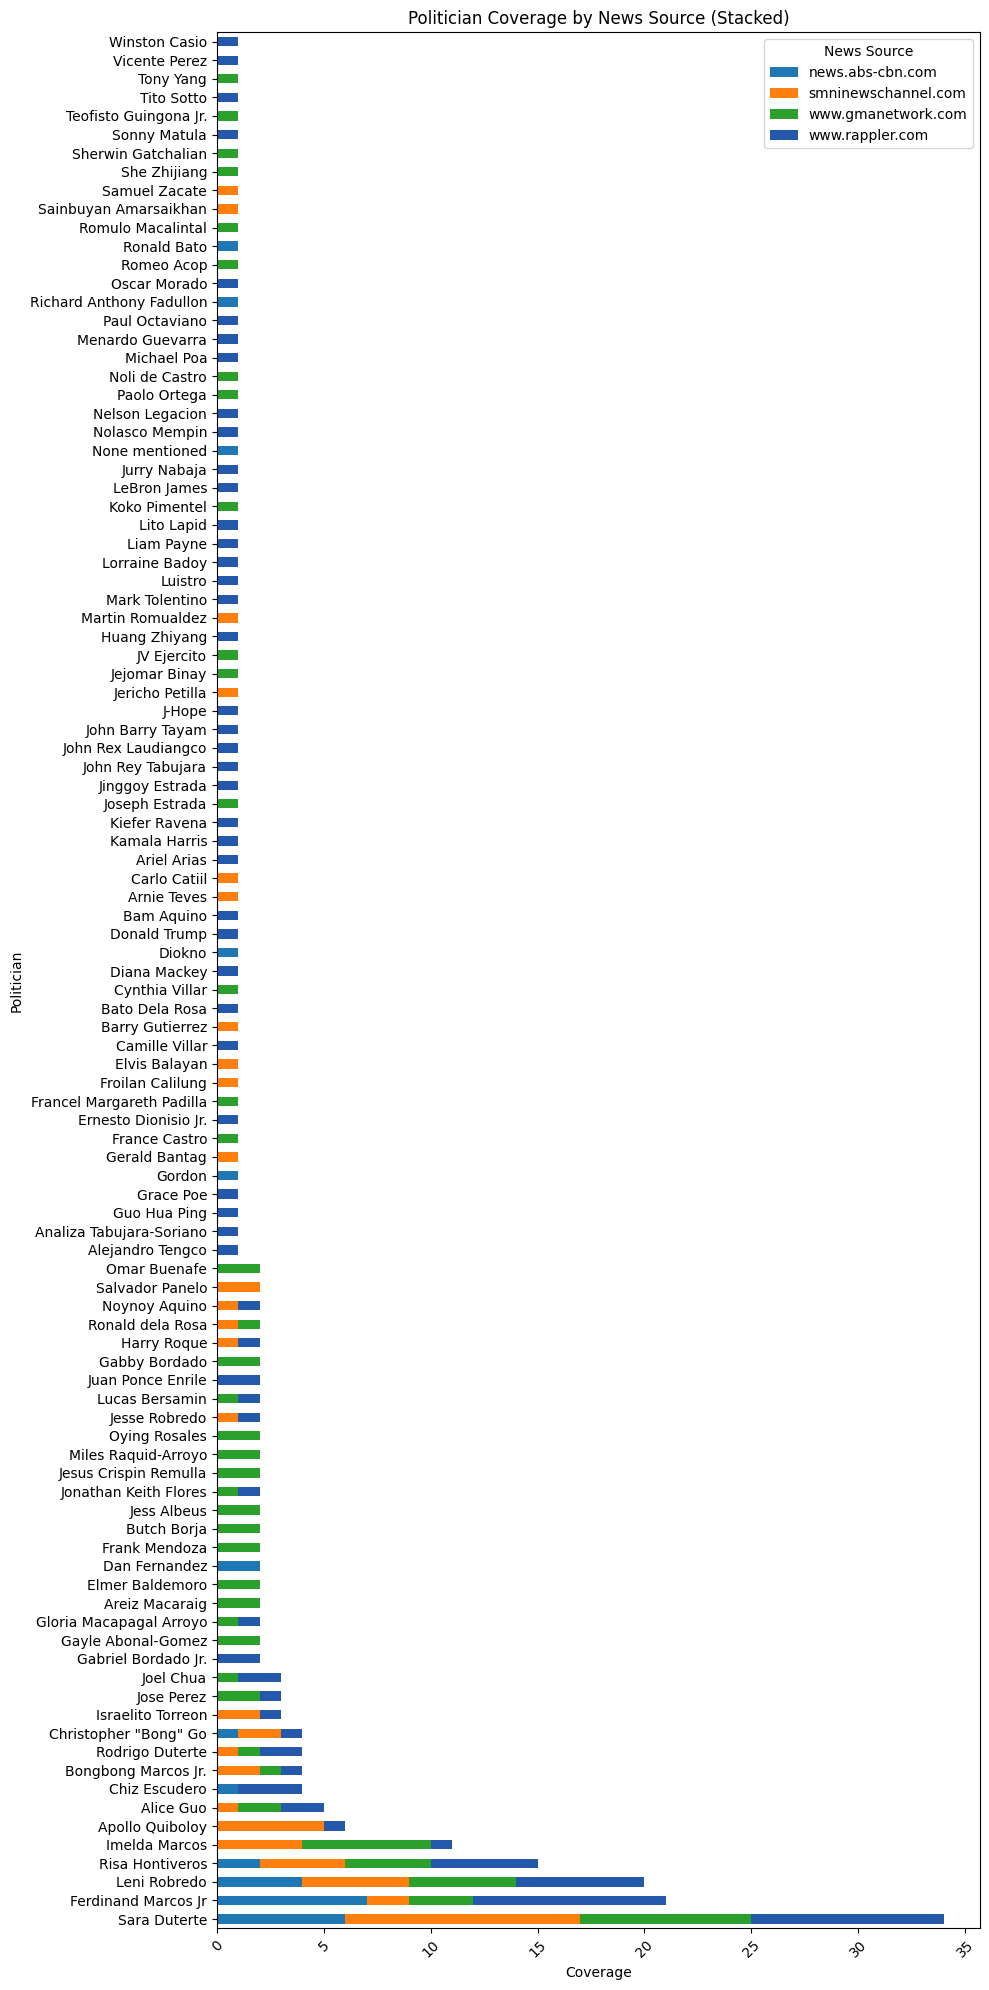

In [463]:

# Plot coverage per politician per source
coverages = []

for source in range(num_sources):
    source_name =source_names[source]
    for i in range(num_politicians):
        politician = politician_names[i]
        coverage = df_og[
           (df_og["politician"] == politician)
           & (df_og["source"] == source_name)
        ]
        coverage = len(coverage)
        coverages.append((politician, source_name, coverage))

# Sort
coverages = sorted(coverages, key=lambda x: x[1], reverse=True)

# Create a DataFrame
df_coverage = pd.DataFrame(coverages, columns=['politician', 'source', 'Coverage'])
# Pivot the DataFrame so each row represents a politician with coverage values per news source
df_pivot = df_coverage.pivot(index='politician', columns='source', values='Coverage')
df_pivot['Coverage'] = df_pivot.sum(axis=1)
df_pivot = df_pivot.sort_values('Coverage', ascending=False).drop('Coverage', axis=1)


# Plotting
ax = df_pivot.plot(kind='barh', stacked=True, 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c',  '#2458ab'], 
                   width=0.5,       
                   figsize=(10,20))


# Customizing the chart
plt.title('Politician Coverage by News Source (Stacked)')
plt.xlabel('Coverage')
plt.ylabel('Politician')
plt.xticks(rotation=45)
plt.legend(title='News Source')

# Show plot

# Increase space between rows
plt.subplots_adjust(hspace=0.9)
plt.tight_layout()



In [464]:
# Test the model

model.eval()
with torch.no_grad():
    for article_embedding, politician, source, sentiment, idxs in dataloader:

        article_embedding = article_embedding.cuda()
        politician = politician.cuda()
        source = source.cuda()
        sentiment = sentiment.float().cuda()

        output = model(article_embedding, politician, source)
        
        for i in range(len(output)):
            idx = int(idxs[i])
            article_title = df_og.iloc[idx]["title"]
            politician_name = df_og.iloc[idx]["politician"]
            source_name = df_og.iloc[idx]["source"]
            sentiment_name = df_og.iloc[idx]["sentiment"]
            predicted_sentiment = output[i]
            
            print(f"Article: {article_title}")
            print(f"Politician: {politician_name}")
            print(f"Source: {source_name}")
            print(f"Sentiment: {sentiment_name}")
            print(f"Predicted Sentiment: {predicted_sentiment}")
            print()

Article: Dating kaalyado ni Leni Robredo, si BBM ang suportado ngayong halalan
Politician: Imelda Marcos
Source: smninewschannel.com
Sentiment: POSITIVE
Predicted Sentiment: -2.0028114318847656

Article: VP Sara Duterte shuns ‘opposition leader’ tag
Politician: Ferdinand Marcos Jr
Source: news.abs-cbn.com
Sentiment: POSITIVE
Predicted Sentiment: -1.9625482559204102

Article: DOJ urged to issue lookout bulletin order on OVP officials
Politician: Jesus Crispin Remulla
Source: www.gmanetwork.com
Sentiment: NEUTRAL
Predicted Sentiment: -0.0020246505737304688

Article: ‘Everyone is welcome in our place’-Ex-VP Leni Robredo sa pagbisita ni VP Sara sa Naga
Politician: Leni Robredo
Source: smninewschannel.com
Sentiment: POSITIVE
Predicted Sentiment: -1.9881691932678223

Article: Ex-VP Leni Robredo files COC for Naga City mayor
Politician: Jess Albeus
Source: www.gmanetwork.com
Sentiment: POSITIVE
Predicted Sentiment: -1.8232812881469727

Article: Arrested preacher Apollo Quiboloy files candidac

102
('Ferdinand Marcos Jr', 2.2129569053649902)
('Samuel Zacate', 1.9431238174438477)
('Vicente Perez', 1.9202332496643066)
('John Rex Laudiangco', 1.6551988124847412)
('Oying Rosales', 1.5906927585601807)
('Ronald dela Rosa', 1.3360391855239868)
('Omar Buenafe', 1.095362663269043)
('She Zhijiang', 0.901823878288269)
('Teofisto Guingona Jr.', 0.8849340081214905)
('Alejandro Tengco', 0.858680784702301)
('John Barry Tayam', 0.8557192087173462)
('Richard Anthony Fadullon', 0.8496776819229126)
('Risa Hontiveros', 0.7922019362449646)
('Camille Villar', 0.7728788256645203)
('Gabriel Bordado Jr.', 0.747399628162384)
('Bato Dela Rosa', 0.7439601421356201)
('Bongbong Marcos Jr.', 0.7316094040870667)
('Diokno', 0.6982290148735046)
('J-Hope', 0.696697473526001)
('Michael Poa', 0.6772857904434204)
('Areiz Macaraig', 0.6528133153915405)
('Imelda Marcos', 0.6491807103157043)
('Noynoy Aquino', 0.5565659403800964)
('Gayle Abonal-Gomez', 0.5551990866661072)
('Gabby Bordado', 0.5246181488037109)
('Franc

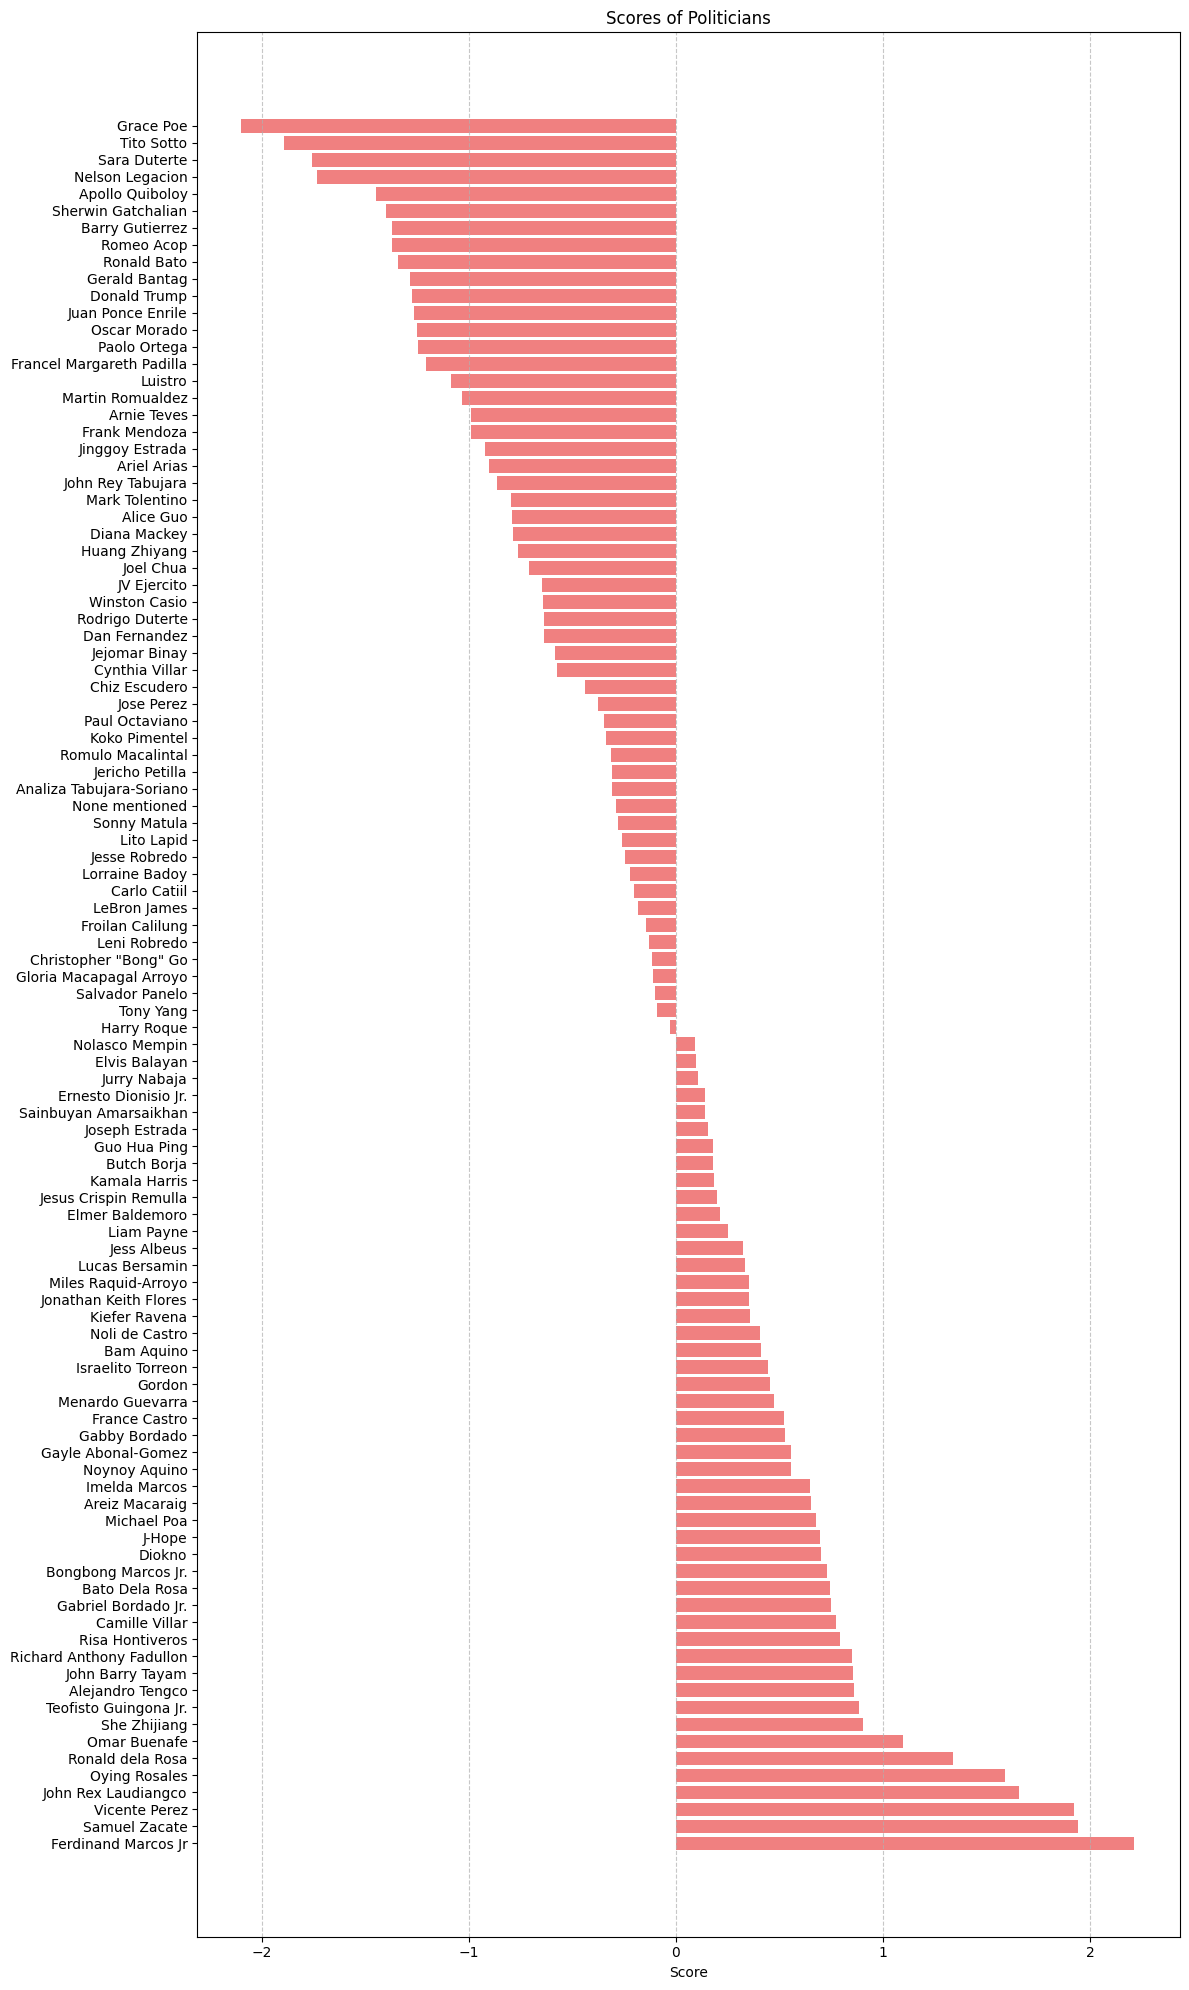

In [465]:
import matplotlib.pyplot as plt

# Print the politician biases log
print(len(model.i_pol.weight))

reps = []
for i in range(num_politicians):
    pol_name = politician_names[i]
    score = (model.i_pol.weight[i].item())
    reps.append((pol_name, score))

reps = sorted(reps, key=lambda x: x[1], reverse=True)
for rep in reps:
    print(rep)

# Unzip the data into two lists
politicians, scores = zip(*reps)

# Create a bar chart
plt.figure(figsize=(12, 20))
plt.barh(politicians, scores, color='lightcoral')
plt.xlabel('Score')
plt.title('Scores of Politicians')
plt.xlim( min(scores)*1.1, max(scores) * 1.1)  # Set xlim for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

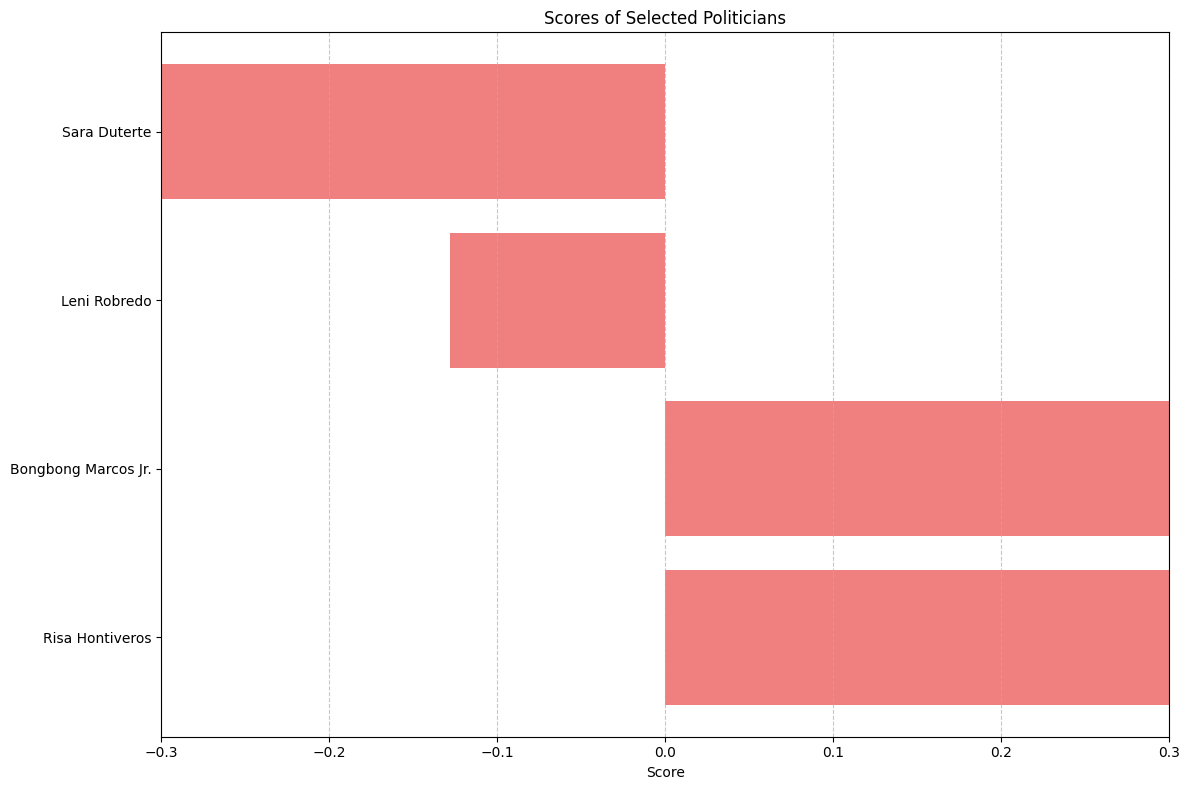

In [466]:
# Whitelist data
whitelist = [
    'Leni Robredo',
    'Risa Hontiveros',
    'Sara Duterte',
    'Bongbong Marcos Jr.',
]

# Filter the data based on the whitelist
filtered_data = [item for item in reps if item[0] in whitelist]

politicians, scores = zip(*filtered_data) if filtered_data else ([], [])

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(politicians, scores, color='lightcoral')
plt.xlabel('Score')
plt.title('Scores of Selected Politicians')
plt.xlim(-0.3, 0.3)   # Set xlim for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


4
('www.rappler.com', 2.2129569053649902)
('www.gmanetwork.com', 0.3316587507724762)
('news.abs-cbn.com', -0.7874764800071716)
('smninewschannel.com', -1.274139165878296)


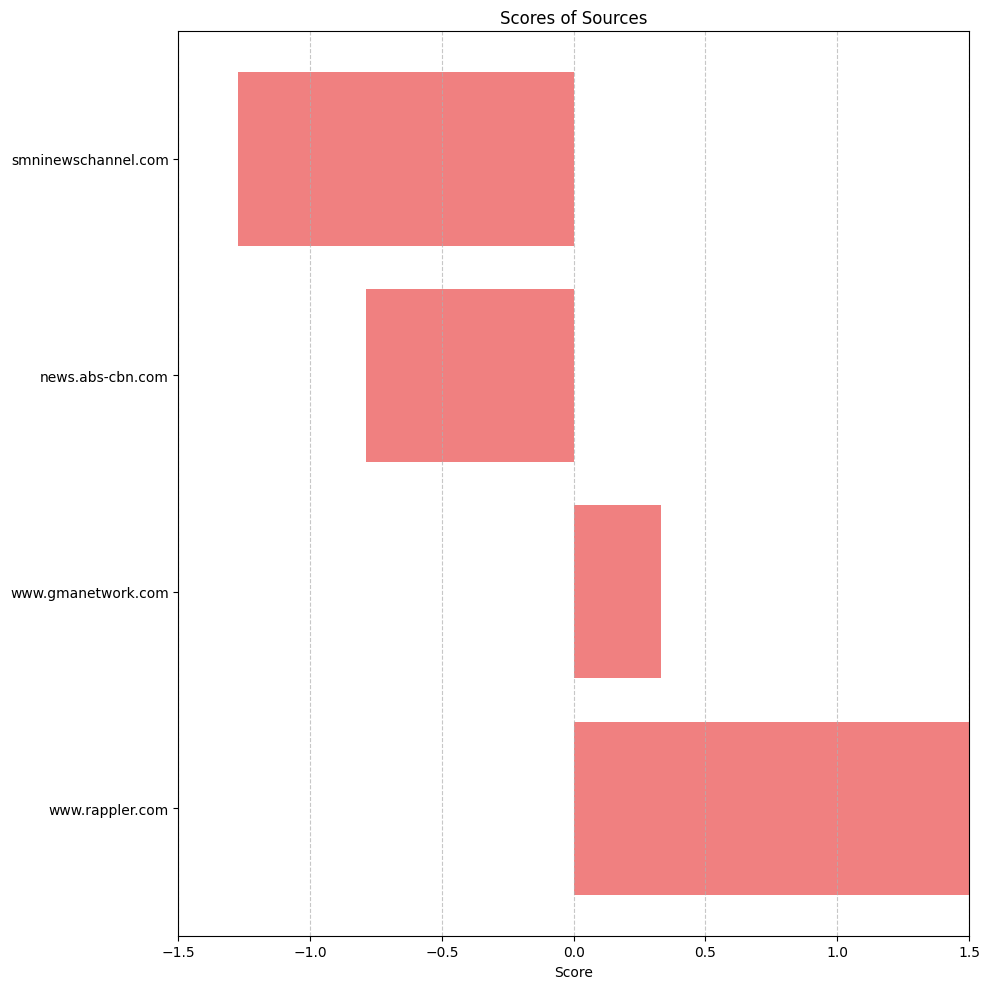

In [467]:
import matplotlib.pyplot as plt

# Print the source biases log
print(len(model.i_source.weight))

reps = []
for i in range(num_sources):
    source_name = source_names[i]
    score = (model.i_pol.weight[i].item())
    reps.append((source_name, score))

reps = sorted(reps, key=lambda x: x[1], reverse=True)
for rep in reps:
    print(rep)

# Unzip the data into two lists
sources, scores = zip(*reps)

# Create a bar chart
plt.figure(figsize=(10, 10))
plt.barh(sources, scores, color='lightcoral')
plt.xlabel('Score')
plt.title('Scores of Sources')
plt.xlim( -1.5, 1.5)  # Set xlim for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()